# Tumour : Multi-Classification

Objectives :
We're going to try and build a model capable of recognising if a patient has a tumour or no !
We'll be using the following kaggle dataset https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mrito train and test our model as well as www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from PIL import UnidentifiedImageError, ImageFile
from IPython.display import Image, display

import zipfile
import os
import pathlib
from pathlib import Path

import tensorflow as tf
import keras


## 1. Exploring our data

In [ ]:
# Extracting the elements contained in the zipfile
dir_name = 'Brain tumour classification kaggle.zip'
zipfile = zipfile.ZipFile(dir_name, 'r')
zipfile.extractall()
zipfile.close()
print('Extraction complete')

Extraction complete


Great, our zipfile has been successfully extracted. Let us now discover the contents of our folder

In [ ]:
directory_path = Path("Brain tumour classification kaggle")
for dirpath, dirnames, filenames in os.walk(directory_path):
    print(f'There are {len(filenames)} images and {len(dirnames)} directories in {dirpath}')

There are 0 images and 2 directories in Brain tumour classification kaggle
There are 0 images and 4 directories in Brain tumour classification kaggle/Testing
There are 306 images and 0 directories in Brain tumour classification kaggle/Testing/meningioma
There are 405 images and 0 directories in Brain tumour classification kaggle/Testing/notumor
There are 300 images and 0 directories in Brain tumour classification kaggle/Testing/glioma
There are 300 images and 0 directories in Brain tumour classification kaggle/Testing/pituitary
There are 0 images and 4 directories in Brain tumour classification kaggle/Training
There are 1339 images and 0 directories in Brain tumour classification kaggle/Training/meningioma
There are 1595 images and 0 directories in Brain tumour classification kaggle/Training/notumor
There are 1321 images and 0 directories in Brain tumour classification kaggle/Training/glioma
There are 1457 images and 0 directories in Brain tumour classification kaggle/Training/pituitar

We can see that we have 12499 images of both cats and dogs !

Let us now put the class names in a list

In [ ]:
# Get the class names
class_names = list(sorted([item.name for item in directory_path.glob('Training/*')]))
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

Text(0.5, 1.0, 'Class name : glioma')

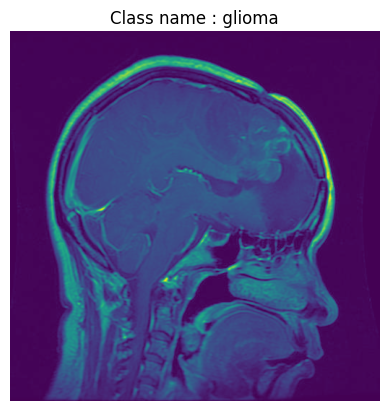

In [ ]:
# Visualize a random image
all_images = list(directory_path.glob('Training/*/*.jpg'))

random_image = random.choice(all_images)
class_name = random_image.parent.name

img=plt.imread(random_image)
plt.imshow(img)
plt.axis(False)

plt.title(f"Class name : {class_name}")

In [ ]:
from PIL import Image
# Create a function capable of visualising a couple of images randomly
def plot_images(directory_path, image_size:tuple=(224, 224), nb_img: int = 9):
    """
    Randomly lots multiple images so as to visualize the dataset we're
    working with

    Args :
        image_size = size of image to resize
        nb_img = number of images to plot
    """
    # Creates a list with all the images of cats and dogs combined
    all_images = list(directory_path.glob('*/*/*.jpg'))

    if nb_img > 9:
        print('ERROR : number of images to plot exceeded, please enter a number smaller or equal to 9')

    else :
        plt.figure(figsize=(10, 10))
        for i in range(nb_img):
            # Create list of unique image directories
            random_img = random.sample(all_images, nb_img)

            # Resize images so that they're all the same size
            img = Image.open(random_img[i])
            image_resized = img.resize(image_size)

            # Find the label of the corresponding image
            label = random_img[i].parent.name

            # Plot the images
            plt.subplot(3, 3, 1+i)
            plt.imshow(image_resized)
            plt.title(label)
            plt.axis(False)



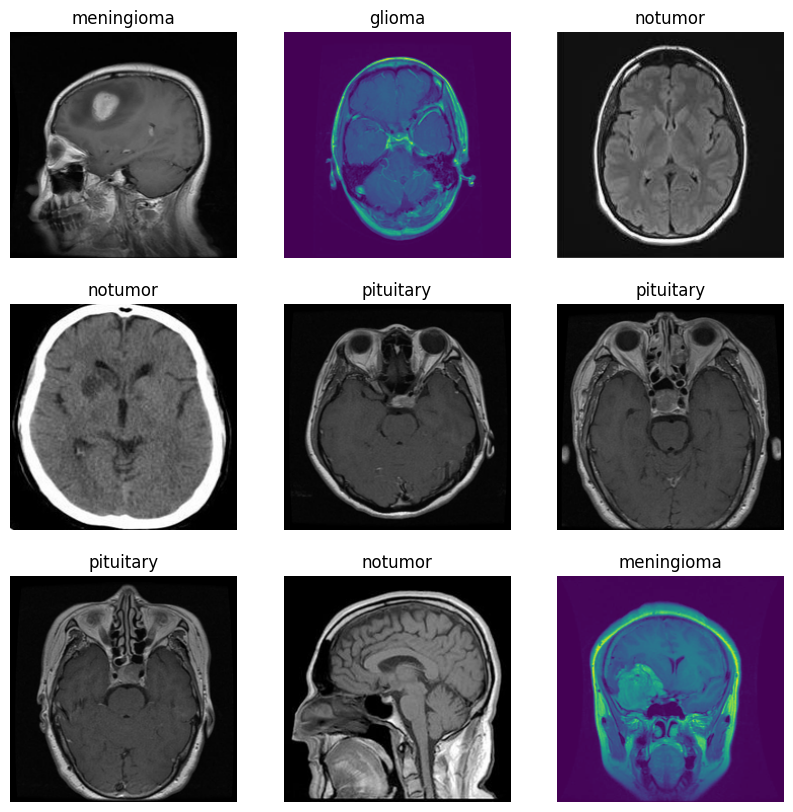

In [ ]:
# Plot images
plot_images(directory_path)

## 2. Preparing our data

Now that we've visualised the data with which we'll be working on, it's time to set up the data !

In [ ]:
# Prevent PIL from silently loading truncated images (optional)
ImageFile.LOAD_TRUNCATED_IMAGES = False

# Path to your dataset
dataset_dir = directory_path

# Counters
total_images = 0
skipped_images = 0

# Loop through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Process each image in place
    for img_name in os.listdir(class_path):
        total_images += 1
        img_path = os.path.join(class_path, img_name)

        try:
            # Check if image is valid
            with Image.open(img_path) as img:
                img.verify()  # raises exception if corrupted

            # Re-open for manipulation
            with Image.open(img_path) as img:
                # Force 3 channels (RGB)
                img = img.convert('RGB')

                # Resize to 224x224 (optional)
                img = img.resize((224, 224))

                # Overwrite original file
                img.save(img_path)

        except (UnidentifiedImageError, OSError, ValueError) as e:
            skipped_images += 1
            print(f"Skipping corrupted/invalid image: {img_path} -> {e}")
            # Optionally delete the corrupted image
            # os.remove(img_path)

print(f"Total images processed: {total_images}")
print(f"Total images skipped: {skipped_images}")


Skipping corrupted/invalid image: Brain tumour classification kaggle/Testing/meningioma -> [Errno 21] Is a directory: 'Brain tumour classification kaggle/Testing/meningioma'
Skipping corrupted/invalid image: Brain tumour classification kaggle/Testing/notumor -> [Errno 21] Is a directory: 'Brain tumour classification kaggle/Testing/notumor'
Skipping corrupted/invalid image: Brain tumour classification kaggle/Testing/glioma -> [Errno 21] Is a directory: 'Brain tumour classification kaggle/Testing/glioma'
Skipping corrupted/invalid image: Brain tumour classification kaggle/Testing/pituitary -> [Errno 21] Is a directory: 'Brain tumour classification kaggle/Testing/pituitary'
Skipping corrupted/invalid image: Brain tumour classification kaggle/Training/meningioma -> [Errno 21] Is a directory: 'Brain tumour classification kaggle/Training/meningioma'
Skipping corrupted/invalid image: Brain tumour classification kaggle/Training/notumor -> [Errno 21] Is a directory: 'Brain tumour classification

In [ ]:
# Creating training and testing datasets
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

training_path  = 'Brain tumour classification kaggle/Training'
validation_path = 'Brain tumour classification kaggle/Testing'

train_ds = tf.keras.utils.image_dataset_from_directory(training_path,
                                                       batch_size = BATCH_SIZE,
                                                       image_size = IMG_SIZE,
                                                       shuffle = True,
                                                       label_mode='categorical',
                                                       seed = 42 # Ensures reproductibility so that we can split the dataset into 75/25%
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(validation_path,
                                                      batch_size = BATCH_SIZE,
                                                      image_size = IMG_SIZE,
                                                      label_mode='categorical',
                                                      seed = 42 # Ensures reproductibility so that we can split the dataset into 75/25%
                                                     )



Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
'''
# Optimize the pipeline
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = train_ds.unbatch()
val_ds  = val_ds.unbatch()

'''

'\n# Optimize the pipeline\ntrain_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)\nval_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)\n\ntrain_ds = train_ds.unbatch()\nval_ds  = val_ds.unbatch()\n\n'

Our images are now seperated into train and datasets, however to make our images more "realistic" we're going to proceed with data augmentation.

In [ ]:
# Data augmentation
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(20/360), # Rotate the image slightly between 0 and 20 degress
    tf.keras.layers.RandomShear(0.2), # shear the image
    tf.keras.layers.RandomZoom(0.2), # Zoom into the image
    tf.keras.layers.RandomTranslation(0.2, 0), # Shift the image witdh ways
    tf.keras.layers.RandomTranslation(0, 0.2), # Shift the image height ways
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomBrightness(factor=0.2)
])

Let's create our base model and try to beat it !

In [ ]:
# Set the seed
tf.random.set_seed(42)

# 1. Create the model
base_model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224,3), batch_size=BATCH_SIZE),
    data_augment,
    tf.keras.layers.Conv2D(filters=32, kernel_size = 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

# 2. Compile the model
base_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ['accuracy'])

In [ ]:
# Fit the model
history_base_model = base_model.fit(train_ds,
                                    validation_data = val_ds,
                                    epochs = 10)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.2675 - loss: 3.7745 - val_accuracy: 0.3089 - val_loss: 1.3129
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.2619 - loss: 1.3894 - val_accuracy: 0.3089 - val_loss: 1.2849
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2677 - loss: 1.4041 - val_accuracy: 0.3105 - val_loss: 1.4452
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.2645 - loss: 1.3863 - val_accuracy: 0.3280 - val_loss: 1.2834
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - accuracy: 0.2664 - loss: 1.3854 - val_accuracy: 0.2616 - val_loss: 1.6134
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.2677 - loss: 1.3934 - val_accuracy: 0.2914 - val_loss: 1.3444
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.2695 - loss: 1.3855 - val_accuracy: 0.2998 - val_loss: 1.3089
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - accuracy: 0.2665 - loss: 1.3858 - 

Great let's visualise the training and test curves

In [ ]:
# Plot the validation and training data seperately

def plot_tt_curves(history):
    """
    Returns seperate loss curves for training and validation metrics.
    """

    loss=history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

      # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

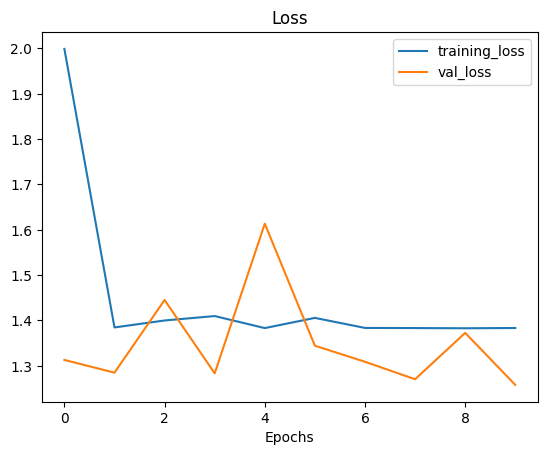

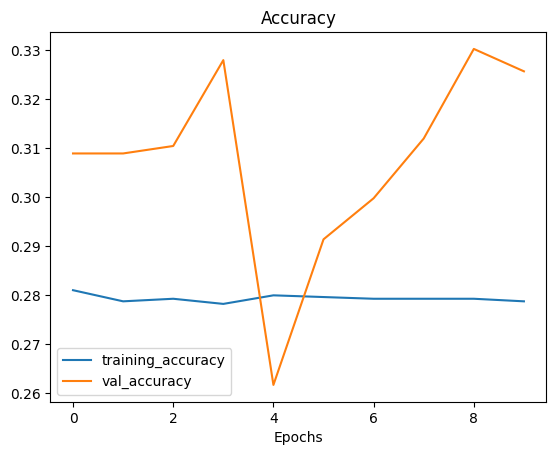

In [ ]:
plot_tt_curves(history_base_model)

Our objective is to have the curves be as close as possible whilst maintaining the best accuracy/loss scores
Let us try and build a model that'll be able to surpass this one with the following changes :
* Add another Dense layer with 256 hidden units
* Add another Conv2D layer

In [ ]:
# Set the seed
tf.random.set_seed(42)

# 1. Create the modem
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224,3), batch_size=BATCH_SIZE),
    data_augment,
    tf.keras.layers.Conv2D(filters=32, kernel_size = 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

# 2. Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ['accuracy'])

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_ds,
                                    validation_data = val_ds,
                                    epochs = 10)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.2696 - loss: 2.0538 - val_accuracy: 0.3089 - val_loss: 1.3831
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2667 - loss: 1.3875 - val_accuracy: 0.3089 - val_loss: 1.3823
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.2674 - loss: 1.3869 - val_accuracy: 0.3089 - val_loss: 1.3790
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.2623 - loss: 1.3871 - val_accuracy: 0.3089 - val_loss: 1.3818
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2666 - loss: 1.3868 - val_accuracy: 0.3089 - val_loss: 1.3800
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.2673 - loss: 1.3864 - val_accuracy: 0.3089 - val_loss: 1.3797
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.2641 - loss: 1.3868 - val_accuracy: 0.3089 - val_loss: 1.3798
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.2628 - loss: 1.3874 - 

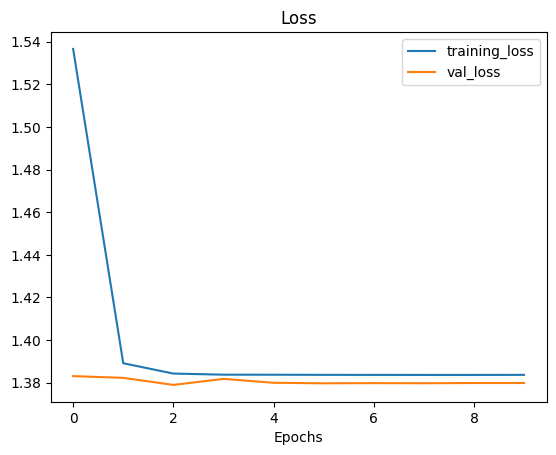

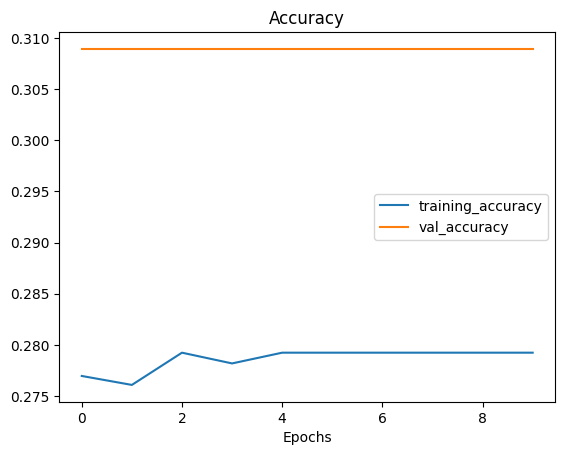

In [ ]:
plot_tt_curves(history_model_1)

Let's try and boost our model's by using transfer learning. We will be using EN716.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

## VGG16 MODEL


In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create the model
vgg = tf.keras.applications.VGG16(include_top = False)
vgg.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
#x = data_augment(inputs)
x = vgg(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(128, activation= 'relu')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation = 'softmax')(x)

vgg_model = tf.keras.Model(inputs, outputs)


In [ ]:
vgg_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,740 (56.14 MB)

 Trainable params: 2,052 (8.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
vgg_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])

# Fit the model
history_vgg = vgg_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 73s 326ms/step - accuracy: 0.4654 - loss: 1.2870 - val_accuracy: 0.6545 - val_loss: 1.0123
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.7468 - loss: 0.9075 - val_accuracy: 0.7079 - val_loss: 0.8495
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.7892 - loss: 0.7442 - val_accuracy: 0.7338 - val_loss: 0.7708
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.8132 - loss: 0.6591 - val_accuracy: 0.7582 - val_loss: 0.7149
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8276 - loss: 0.5981 - val_accuracy: 0.7696 - val_loss: 0.6762
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8394 - loss: 0.5522 - val_accuracy: 0.7834 - val_loss: 0.6515
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8382 - loss: 0.5291 - val_accuracy: 0.7933 - val_loss: 0.6244
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.8562 - loss: 0

Let's fine tune the VGG model

In [ ]:
# Make all the layers in vgg_model trainable
vgg_model.trainable = True

# Freeze all layers except for the last 10
for layer in vgg_model.layers[:-10]:
  layer.trainable = False

# Recompile model
vgg_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Fine tune for another 5 epochs
initial_epochs=10
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_vgg_fined_tuned = vgg_model.fit(train_ds,
                                               epochs=fine_tune_epochs,
                                               validation_data=val_ds,
                                               initial_epoch=history_vgg.epoch[-1],
                                               )

Epoch 10/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.8685 - loss: 0.4451 - val_accuracy: 0.8108 - val_loss: 0.5727
Epoch 11/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.8685 - loss: 0.4375 - val_accuracy: 0.8124 - val_loss: 0.5712
Epoch 12/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8672 - loss: 0.4374 - val_accuracy: 0.8108 - val_loss: 0.5699
Epoch 13/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8691 - loss: 0.4361 - val_accuracy: 0.8116 - val_loss: 0.5677
Epoch 14/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.8708 - loss: 0.4348 - val_accuracy: 0.8108 - val_loss: 0.5663
Epoch 15/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.8704 - loss: 0.4348 - val_accuracy: 0.8116 - val_loss: 0.5649


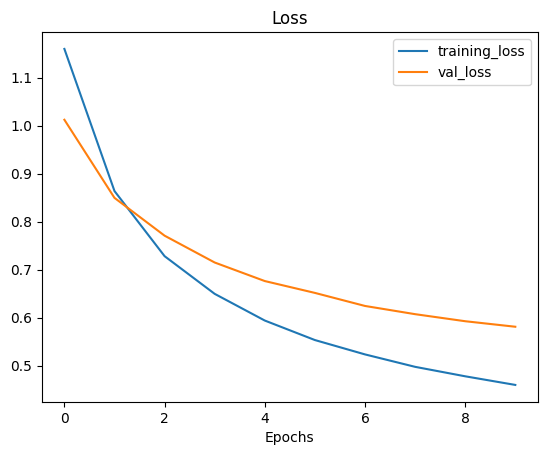

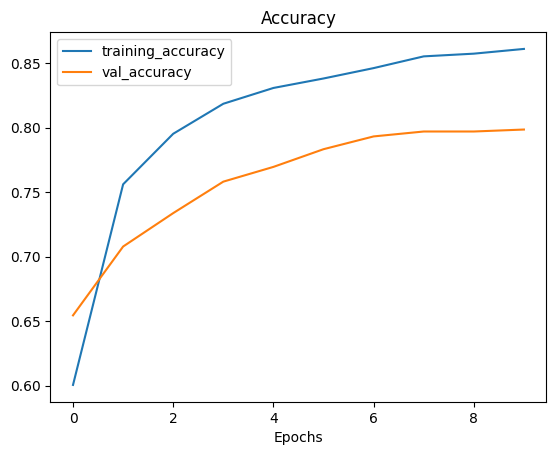

In [ ]:
plot_tt_curves(history_vgg)

## Inception V3 Model

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Create the model
In3 = tf.keras.applications.InceptionV3(include_top = False)
In3.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
#x = data_augment(inputs)
x = In3(inputs, training = False)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', name='gradcam_conv')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dropout(0.3)(x)
#x = tf.keras.layers.Dense(128, activation= 'relu')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation = 'softmax')(x)

In3_model = tf.keras.Model(inputs, outputs)


In [ ]:
# Compile the model
In3_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])

# Fit the model
history_In3 = In3_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 10)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 57s 220ms/step - accuracy: 0.6867 - loss: 1.2824 - val_accuracy: 0.8459 - val_loss: 0.3751
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.8897 - loss: 0.2977 - val_accuracy: 0.8596 - val_loss: 0.3239
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.9229 - loss: 0.2122 - val_accuracy: 0.8658 - val_loss: 0.3441
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.9346 - loss: 0.1799 - val_accuracy: 0.9001 - val_loss: 0.2492
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9547 - loss: 0.1339 - val_accuracy: 0.9214 - val_loss: 0.1940
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.9607 - loss: 0.1136 - val_accuracy: 0.9245 - val_loss: 0.2072
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.9721 - loss: 0.0791 - val_accuracy: 0.9252 - val_loss: 0.1926
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.9741 - loss: 0.0730

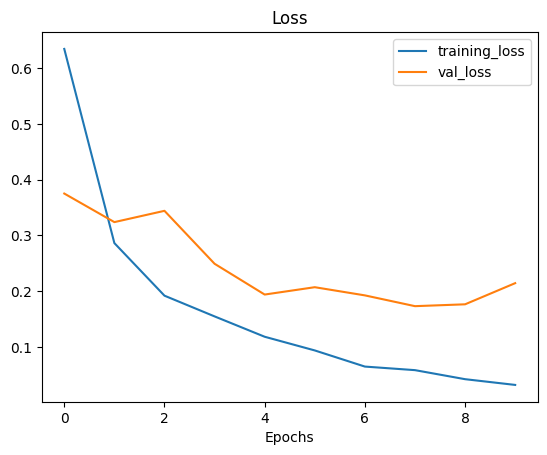

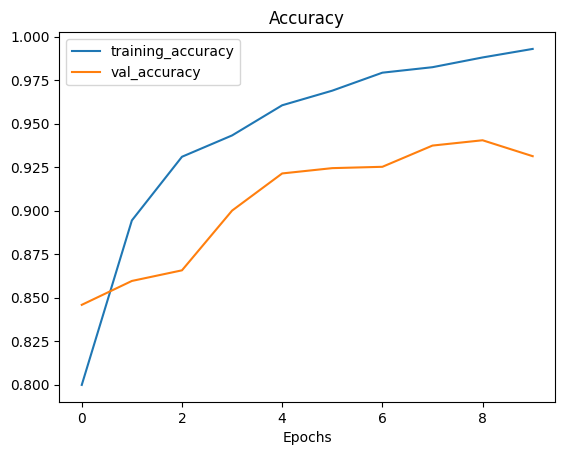

In [ ]:
plot_tt_curves(history_In3)

In [ ]:
# save model
In3_model.save("best_model.keras")

Let us try and predict a couple of images !

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis("off")
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    prediction = In3_model.predict(img)
    pred_class_index = np.argmax(prediction[0])
    pred_confidence = prediction[0][pred_class_index]
    print(f"Prediction probability: {pred_confidence:.4f}")
    print(f'class : {class_names[pred_class_index]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction probability: 0.9997
class : notumor


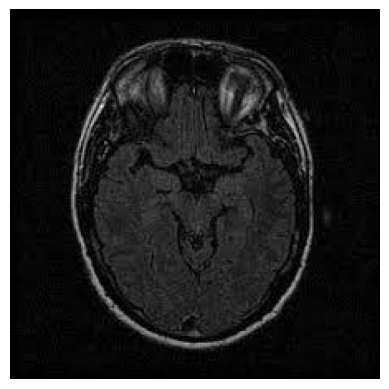

In [ ]:
predict_image('No tumour.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction probability: 0.9985
class : meningioma


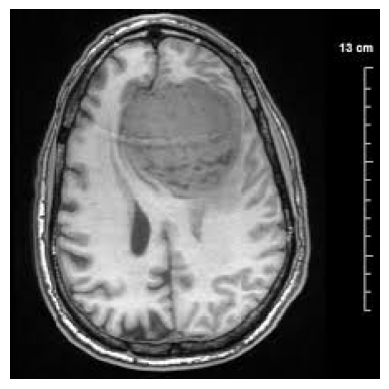

In [ ]:
predict_image('Meningioma tumour.jpg')

## Test our model on a new dataset

In [ ]:
import zipfile  # make sure you import the module

dir_name = '/content/Tumour classification.zip'

# Use a different variable name
with zipfile.ZipFile(dir_name, 'r') as zip_ref:
    zip_ref.extractall()  # extracts to current directory


In [ ]:
New_dir_path = Path('Tumour classification/Training')
test_ds = tf.keras.utils.image_dataset_from_directory(New_dir_path,
                                                      image_size=IMG_SIZE,
                                                      batch_size=BATCH_SIZE,
                                                      label_mode='categorical')


test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 2870 files belonging to 4 classes.


In [ ]:
import numpy as np

# Extract predictions and labels from test dataset
y_true = []
y_pred_prob = []

for x, y in test_ds:
    y_true.append(y.numpy())
    y_pred_prob.append(In3_model.predict(x, verbose=0))

# Concatenate all batches
y_true = np.concatenate(y_true, axis=0)
y_pred_prob = np.concatenate(y_pred_prob, axis=0)

# Convert one-hot to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

In [ ]:
# Creating a metrics function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def model_results(y_true, y_pred):
    """
    Function to show to different metrics.
    """

    # Accuracy score :
    acc = accuracy_score(y_true, y_pred)

    #precision, recall, fscore
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    dic={"accuracy": acc, "precision": precision, "recall": recall, "f1-score": f1_score}

    return dic

In [ ]:
model_results(y_true_classes, y_pred_classes)

{'accuracy': 0.9543554006968641,
 'precision': 0.9584690513010949,
 'recall': 0.9543554006968641,
 'f1-score': 0.9541424602470123}

Confusion Matrix:
 Axes(0.125,0.11;0.62x0.77)
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       826
           1       0.88      0.99      0.93       822
           2       0.96      1.00      0.98       395
           3       1.00      0.99      0.99       827

    accuracy                           0.95      2870
   macro avg       0.96      0.96      0.96      2870
weighted avg       0.96      0.95      0.95      2870



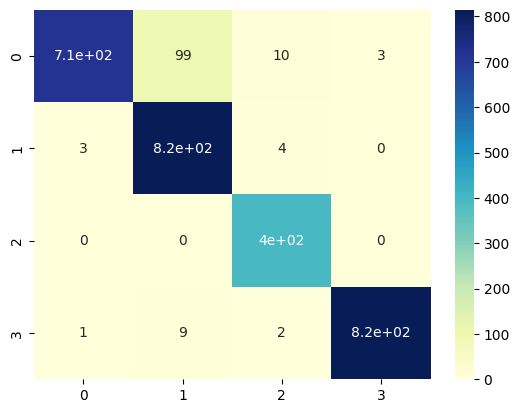

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Confusion Matrix:\n", sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes), annot=True,  cmap='YlGnBu'))
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

## Let us see how the model makes predictions by using Grad Cam

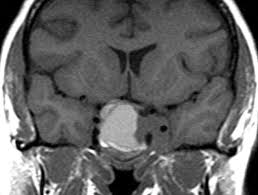

In [2]:
from PIL import Image
from IPython.display import display

# Check for the last layer in our model
last_conv_layer_name = "gradcam_conv"

display(Image.open('P2.jpg'))

In [ ]:
def get_img_array(img_path, size):
  """
  Load and transform image into an array

  Parameter
    img_path : path of the image
    size = size to transform image into
  """
  img = keras.utils.load_img(img_path, target_size = size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0) # For batch dimension
  array = array/255.0
  return array


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # Create new model to map the input image to the activations of the las_conv_layer as well as the predictions
  grad_model = keras.Model(model.inputs,
   [model.get_layer(last_conv_layer_name).output, model.output])

  # Compute the gradient of top predicted class wrt the activations of the last conv layer
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

    # Gradient of the ouptut neuron wrt the ouput feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Get the average of each feature maps after applying the gradient to get the weights of the feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by the wieght we've just calculated then sum them all to obtain the heatmap
    last_conv_layer_outptut = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualisation purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
# Create a superimposed visualization
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted: 1.0


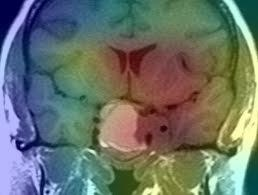

In [ ]:
# Prepare image
img_array = get_img_array('/content/m3 (9).jpg', size=IMG_SIZE)

# Make model
model = In3_model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
pred_class_index = np.argmax(preds[0])
print("Predicted:", preds[0][pred_class_index])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam('/content/P2.jpg', heatmap)
